# Project Description

A supermarket is implementing a computer vision system to process customer photos. Photo recording in the checkout area will help determine the age of customers in order to:
Analyze purchases and offer products that may be of interest to buyers of this age group;
Monitor the integrity of cashiers when selling alcohol.
Build a model that will determine the approximate age of a person from a photograph. At your disposal is a set of photographs of people indicating their age.

# Execution Sequence

1. Conduction an exploratory analysis of a set of photographs.
2. Preparing the data for training.
3. Training a neural network and calculate its quality.

## Exploratory data analysis

In [1]:
# import data extraction honey
# connecting the necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error
import seaborn as sns
from PIL import Image
# connecting the necessary libraries and modules for training
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

In [ ]:
# download the data
labels=pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255)
train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                 directory='/datasets/faces/final_files',
                 target_size=(224, 224),
                 batch_size=32,
                 class_mode='raw',
                 x_col='file_name',
                 y_col='real_age',
                 seed=12345)

The uploader found 7591 images

In [16]:
# dataset size
labels.shape

(7591, 2)

In [17]:
# let's look at the dataset
print(labels.info)
print(labels.info())

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [18]:
# data statistics
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Minimum age 1 year, maximum 100 years. The average value of the data set is at 31.20, we see that the median (29) is close to the average.

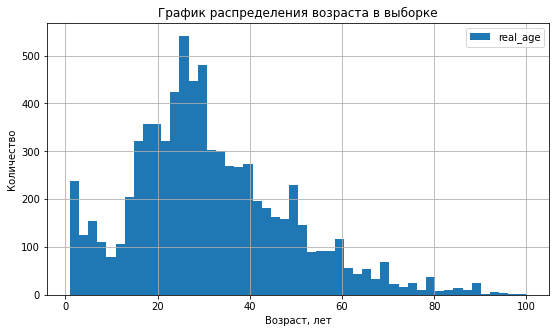

In [19]:
# age distribution
labels.plot(kind='hist',figsize=(9,5),bins=50, grid=True)
plt.title('Graph of age distribution in the sample')
plt.xlabel('Age, years')
plt.ylabel('Quantity')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


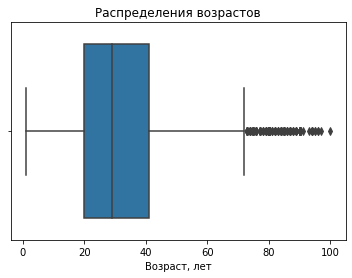

In [20]:
# age distribution boxplot
sns.boxplot(labels['real_age'])
plt.title('Age distribution')
plt.xlabel('Age, years')
plt.show();

The diagrams show that the peak values ​​occur between ages 20 and 40.

In [21]:
before_20 = labels['real_age']<=20
between_20_40 = (labels['real_age']>20) & (labels['real_age']<=40)
between_40_70 = (labels['real_age']>40) & (labels['real_age']<=70)
after_70 = labels['real_age']>70

print('Before 20 лет:', before_20.mean(),
     '20-40 лет:', between_20_40.mean(),
     '40-70 лет:', between_40_70.mean(),
     'За 70 лет:', after_70.mean())

До 20 лет: 0.27058358582531944 20-40 лет: 0.47793439599525755 40-70 лет: 0.22618890791727045 За 70 лет: 0.02529311026215255


In [22]:
# highlight in the dataset features and target
features,target=next(train_datagen_flow)
print(features.shape)

(32, 224, 224, 3)


The resulting features are a four-dimensional tensor, in which there are 32 images of size 224x224 with three color channels.

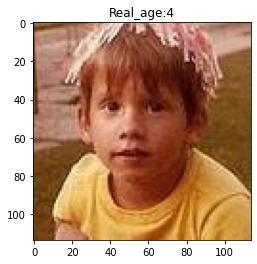

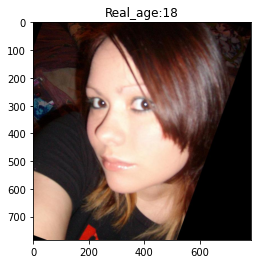

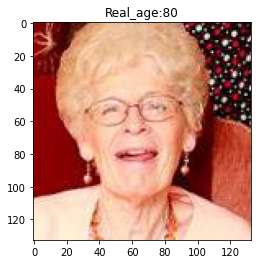

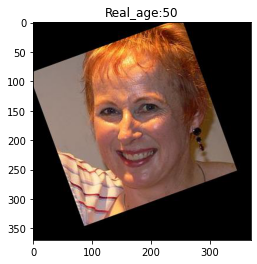

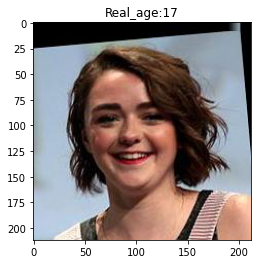

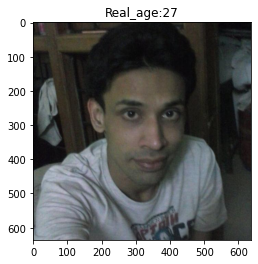

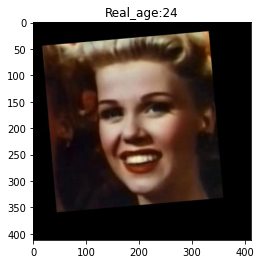

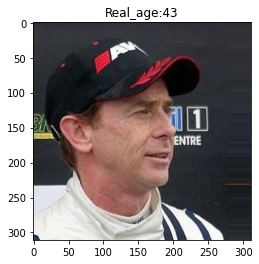

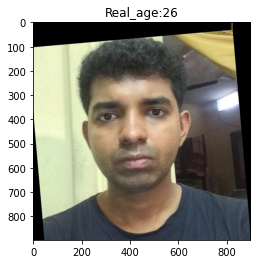

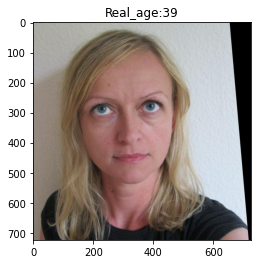

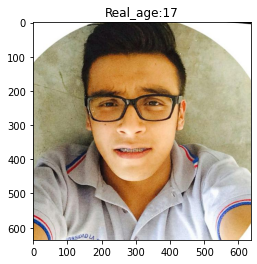

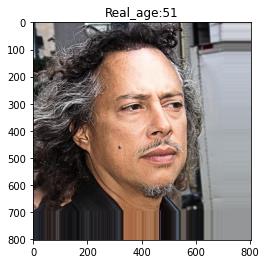

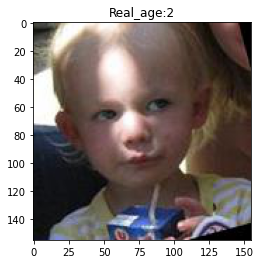

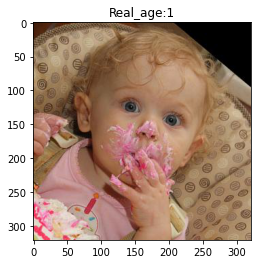

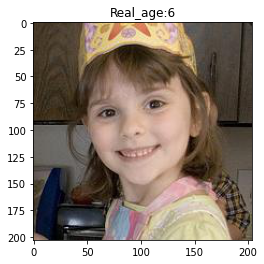

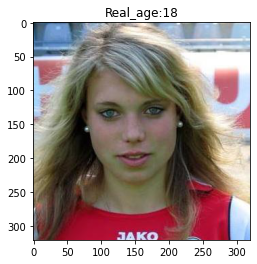

In [23]:
# display 16 photos on the screen
for i, k in zip (labels.file_name[:16], labels.real_age[:16]):
    image=Image.open('/datasets/faces/final_files/'+i)
    plt.imshow(np.array(image))
    plt.title('Real_age:{:.0f}'.format(k))
    plt.show()
   

Conclusion from research analysis:
During the exploratory analysis, we found that the dataset consists of 7591 photos for each photo. For each photo, the age of the person in the photo is indicated. Age varies from 1 to 100 years. The average age is about 31 years. At the same time, the largest number of photos falls on people aged 20-40 years (about 48%), under 20 years old (27%) in second place, followed by the group 40-70 years old (22%). Over 70 years old - the number of photos is very small, about 2%. In general, the distribution is normal and skewed to the right.
No gaps were found in the data.
After uploading 16 photos, we see that not all photos are located vertically, there are photos that are not very clear, blurry, the presence of glasses, dirty faces, or the presence of a hand that covers part of the face may complicate the training.


## Data preparation and model training

In [24]:
# импорт библиотек
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

In [25]:
# training set loading function
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True, # Let's add augmentation
    vertical_flip=True)
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return train_data


In [26]:
# test sample loading function
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1/255.)
    
    test_data = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return test_data

In [27]:
# model loading function
def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0001)
    backbone = ResNet50(input_shape=(224,224,3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model=Sequential()
    model.add(backbone)

    model.add(AvgPool2D())
    model.add(Flatten())

    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    
    return model

In [28]:
# model training
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model

result of training and testing

2023-09-15 16:53:29.617316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-09-15 16:53:29.619073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-09-15 16:53:30.484114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-15 16:53:30.501171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-15 16:53:30.501284: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-15 16:53:30.501348: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-15 16:53:30.503534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-15 16:53:30.504008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-15 16:53:30.506642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-15 16:53:30.508189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-15 16:53:30.508265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-15 16:53:30.512694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-09-15 16:53:31.504054: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-09-15 16:53:31.514840: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-09-15 16:53:31.516010: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4cf5b00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-15 16:53:31.516049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-15 16:53:31.663493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4bcb870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-15 16:53:31.663531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-09-15 16:53:31.665370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-15 16:53:31.665445: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-15 16:53:31.665460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-15 16:53:31.665498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-15 16:53:31.665515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-15 16:53:31.665532: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-15 16:53:31.665548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-15 16:53:31.665559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-15 16:53:31.668973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-09-15 16:53:31.669044: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-15 16:53:32.037620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-15 16:53:32.037672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-09-15 16:53:32.037680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-09-15 16:53:32.040685: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-15 16:53:32.040735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-09-15 16:53:42.233501: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-15 16:53:42.530809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 10.4635 - mae: 10.4588 - val_loss: 18.0174 - val_mae: 17.9965
Epoch 2/10
178/178 - 42s - loss: 7.9730 - mae: 7.9732 - val_loss: 15.5934 - val_mae: 15.5629
Epoch 3/10
178/178 - 40s - loss: 7.1565 - mae: 7.1562 - val_loss: 12.5895 - val_mae: 12.5623
Epoch 4/10
178/178 - 41s - loss: 6.6080 - mae: 6.6085 - val_loss: 10.2741 - val_mae: 10.2793
Epoch 5/10
178/178 - 41s - loss: 5.9276 - mae: 5.9280 - val_loss: 9.6485 - val_mae: 9.6802
Epoch 6/10
178/178 - 40s - loss: 5.6766 - mae: 5.6770 - val_loss: 7.6747 - val_mae: 7.6963
Epoch 7/10
178/178 - 40s - loss: 5.4410 - mae: 5.4411 - val_loss: 6.6585 - val_mae: 6.6685
Epoch 8/10
178/178 - 40s - loss: 5.0099 - mae: 5.0101 - val_loss: 7.5278 - val_mae: 7.5577
Epoch 9/10
178/178 - 40s - loss: 4.7218 - mae: 4.7220 - val_loss: 6.3912 - val_mae: 6.4187
Epoch 10/10
178/178 - 40s - loss: 4.6191 - mae: 4.6196 - val_loss: 6.4752 - val_mae: 6.5154
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.4752 - mae: 6.5154
Test MAE: 6.515

## Model Analysis


Our task was to train the model to recognize how old a person is from a photograph; the model’s assessment is MAE (absolute deviation), which should be less than 7. To complete the task, we have a dataset of 7591 images. During the research analysis, we found out that we have photographs depicting people from 1 to 100 years old. The largest number of photographs are presented within the age range of 20-40 years.

During training, the models revealed that when training the model on 5 epochs, MAE was higher than 7, so we increased the number of epochs to 10. We see that during training, MAE on the training set drops from 10.46 to 4.62, on the test set from 18.02 to 6.515. Training could have been stopped at epoch 9, since the result of MAE 6.42 was lower than the final one. But still, I think that increasing the number of epochs from 10 to 15 resulted in an even lower MAE.